In [12]:
from torch.utils.data import DataLoader, random_split
# from utils.preprocess import FaceCompletionDataset
from utils.network_seq_contour import Parser
from utils.models import Generator, Discriminator
import torchvision.models as models
import torch
import copy
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

class FaceCompletionDataset(Dataset):
    def __init__(self, image_dir, block_size=(64, 64)):
        self.image_dir = image_dir
        self.block_size = block_size
        self.image_list = os.listdir(image_dir)[:64*5]
        
    def __len__(self):
        return len(self.image_list)
    
    def random_block_mask(self, image, block_size=(64, 64)):
        h, w, _ = image.shape
        x = random.randint(0, w - block_size[0])
        y = random.randint(0, h - block_size[1])
        mask = np.zeros((h, w), dtype=np.uint8)
        mask[y:y + block_size[1], x:x + block_size[0]] = 1
        masked_image = image.copy()
        noise = np.random.randint(0, 256, size=(block_size[1], block_size[0], 3), dtype=np.uint8)
        masked_image[y:y + block_size[1], x:x + block_size[0]] = noise
        return masked_image, mask
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_list[idx])
        image = cv2.imread(image_path)

        masked_image, mask = self.random_block_mask(image)
        #mask = np.expand_dims(mask, axis=0)
    
        image = ToTensor()(image)
        #mask = ToTensor()(mask)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) 
        masked_image = ToTensor()(masked_image)
 
        return image, mask, masked_image


image_dir = "preprocessed_images/"
save_path = './model_trained/'
celeba_dataset = FaceCompletionDataset(image_dir)


In [21]:
from utils.networks import GatedGenerator

In [13]:
# Assuming your_dataset is an instance of your Dataset class
train_size = int(0.8 * len(celeba_dataset))  # Use 80% of the dataset for training
val_size = len(celeba_dataset) - train_size

train_dataset, val_dataset = random_split(celeba_dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
validation_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

In [14]:
torch.cuda.empty_cache()

In [15]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [16]:
from argparse import ArgumentParser, Namespace
import yaml
def return_image_numpy(images, scale=False):
    if scale:
        completed_images_np = images[0].cpu().detach().numpy()
 
        completed_images_np = ((completed_images_np + 1) * 127.5)
        print(completed_images_np.shape)
        return completed_images_np.transpose(1, 2, 0)
    else:
        return images[0].detach().cpu().numpy().transpose(1, 2, 0)

def get_config(config_file):
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
    return config

def get_args():
    parser = ArgumentParser()
    parser.add_argument('--config', type=str, default='config/seg_config.yaml', help="training configuration")
    parser.add_argument('--seed', type=int, default=2023, help='manual seed')

    try:
        args = parser.parse_args()
    except SystemExit:
        args = Namespace(config='config/seg_config.yaml', seed=2023)
    return args

def load_face_parsing_model(model_path):
    
    netG.load_state_dict(torch.load(model_path), strict=False)
    netG.eval()
    return netG

def gradient_penalty(discriminator, real_images, fake_images):
    batch_size = real_images.size(0)

    # Create epsilon values for interpolating between real and fake images
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
    epsilon = epsilon.expand_as(real_images)

    # Interpolate between real and fake images
    interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images
    interpolated_images.requires_grad_(True)

    # Compute the discriminator's output on the interpolated images
    interpolated_output = discriminator(interpolated_images)

    # Compute the gradients of the output with respect to the input images
    gradients = torch.autograd.grad(
        outputs=interpolated_output,
        inputs=interpolated_images,
        grad_outputs=torch.ones_like(interpolated_output),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    # Compute the gradient penalty
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1)**2).mean()

    return penalty


def discriminator_loss(real_output, fake_output):
    return fake_output.mean() - real_output.mean()

def generator_loss(fake_output):
    return -fake_output.mean()

## load parser network
args = get_args()
config = get_config(args.config)
netG = Parser(config)

# load parsing model
face_parsing_model = load_face_parsing_model('pretrained_model/parser_00100000.pt')
face_parsing_model = face_parsing_model.to(device)
face_parsing_model.eval()

usage: ipykernel_launcher.py [-h] [--config CONFIG] [--seed SEED]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/x1112373/.local/share/jupyter/runtime/kernel-c219fe6d-e60b-4d87-8062-74644e43a9f2.json


Parser(
  (conv1_1): Conv2dBlock(
    (pad): ZeroPad2d((0, 0, 0, 0))
    (activation): ELU(alpha=1.0, inplace=True)
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  )
  (conv1_2): Conv2dBlock(
    (pad): ZeroPad2d((0, 0, 0, 0))
    (activation): ELU(alpha=1.0, inplace=True)
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv2_1): Conv2dBlock(
    (pad): ZeroPad2d((0, 0, 0, 0))
    (activation): ELU(alpha=1.0, inplace=True)
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2_2): Conv2dBlock(
    (pad): ZeroPad2d((0, 0, 0, 0))
    (activation): ELU(alpha=1.0, inplace=True)
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv3_1): Conv2dBlock(
    (pad): ZeroPad2d((0, 0, 0, 0))
    (activation): ELU(alpha=1.0, inplace=True)
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv3_2): Conv2dBlock(
    (pad): Z

In [40]:
#Source: https://github.com/Po-Hsun-Su/pytorch-ssim.git

import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [41]:
step_iters = [50000, 75000, 100000]
def adjust_learning_rate(optimizer, gamma=0.1, num_steps=1):
    for i in range(num_steps):
        for param_group in optimizer.param_groups:
            param_group['lr'] *= gamma

In [51]:
class GANLoss(nn.Module):
    def __init__(self, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.loss = nn.MSELoss()

    def get_target_tensor(self, input, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(input)

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real).to(input.device)
        return self.loss(input, target_tensor)

In [52]:
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.models import Generator, Discriminator

## initialize first model
generator = GatedGenerator()
discriminator_global = Discriminator(in_channels=3)
discriminator_local = Discriminator(in_channels=3)

## loss
criterion_context = nn.MSELoss(reduction='sum')
criterion_adv = GANLoss(target_real_label=0.9, target_fake_label=0.1)
#criterion_adv = nn.BCEWithLogitsLoss() ## beforehand
criterion_parsing = nn.SmoothL1Loss()
criterion_rec = nn.SmoothL1Loss()
criterion_ssim = SSIM(window_size = 11)
# Create Optimizer
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.0001)
optimizer_discriminator_global = torch.optim.Adam(generator.parameters(), lr=0.0001)
optimizer_discriminator_local = torch.optim.Adam(generator.parameters(), lr=0.0001)

# Create the schedulers
# scheduler_generator = ReduceLROnPlateau(optimizer_generator, mode='min', factor=0.1, patience=5, verbose=True)
# scheduler_discriminator_global = ReduceLROnPlateau(optimizer_discriminator_global, mode='min', factor=0.1, patience=5, verbose=True)
# scheduler_discriminator_local = ReduceLROnPlateau(optimizer_discriminator_local, mode='min', factor=0.1, patience=5, verbose=True)

# device setting
generator = generator.to(device)
discriminator_global = discriminator_global.to(device)
discriminator_local = discriminator_local.to(device)


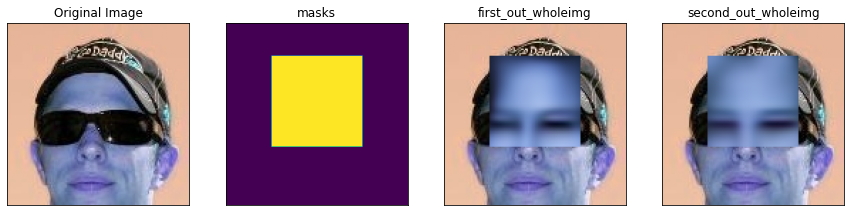

Epoch: 0, Step: 63, Training Losses - Generator: 17.773788452148438
0
Epoch: 0, Validation Losses - Generator: 12.68754566, Discriminator Global: 0.38912451, Discriminator Local: 0.30973754
Epoch: 0, Validation PSNR: 11.76639712, SSIM: 0.49749944


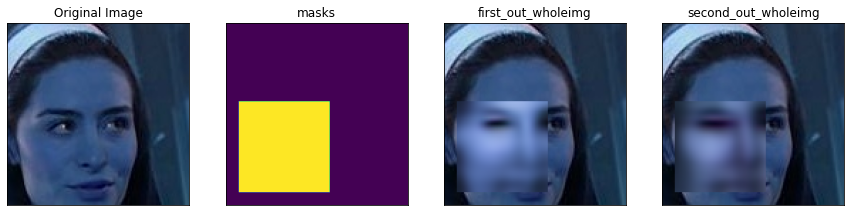

Epoch: 1, Step: 63, Training Losses - Generator: 17.867698669433594
0
Epoch: 1, Validation Losses - Generator: 12.96511590, Discriminator Global: 0.38975872, Discriminator Local: 0.30928401
Epoch: 1, Validation PSNR: 11.74287174, SSIM: 0.49998687


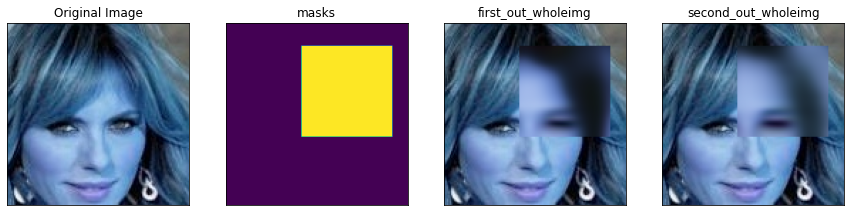

Epoch: 2, Step: 63, Training Losses - Generator: 17.871612548828125
0
Epoch: 2, Validation Losses - Generator: 12.65879691, Discriminator Global: 0.38969944, Discriminator Local: 0.30889692
Epoch: 2, Validation PSNR: 11.76703858, SSIM: 0.49787060


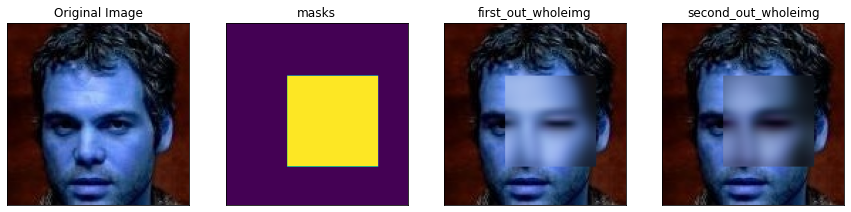

Epoch: 3, Step: 63, Training Losses - Generator: 16.305191040039062
0
Epoch: 3, Validation Losses - Generator: 12.70672941, Discriminator Global: 0.38910697, Discriminator Local: 0.30932421
Epoch: 3, Validation PSNR: 11.84679335, SSIM: 0.49444515


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


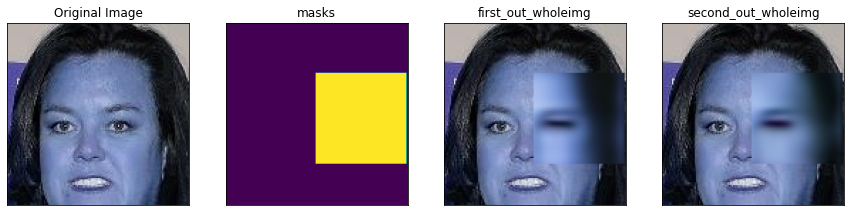

Epoch: 4, Step: 63, Training Losses - Generator: 18.692262649536133
0
Epoch: 4, Validation Losses - Generator: 12.79116720, Discriminator Global: 0.38935394, Discriminator Local: 0.30941463
Epoch: 4, Validation PSNR: 11.77829904, SSIM: 0.49382533


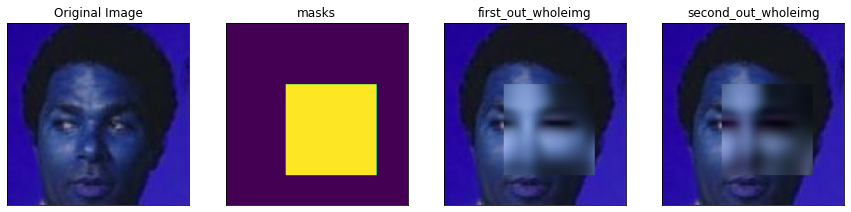

Epoch: 5, Step: 63, Training Losses - Generator: 18.124582290649414
0
Epoch: 5, Validation Losses - Generator: 12.72940660, Discriminator Global: 0.38948176, Discriminator Local: 0.30927837
Epoch: 5, Validation PSNR: 11.69968977, SSIM: 0.49955657


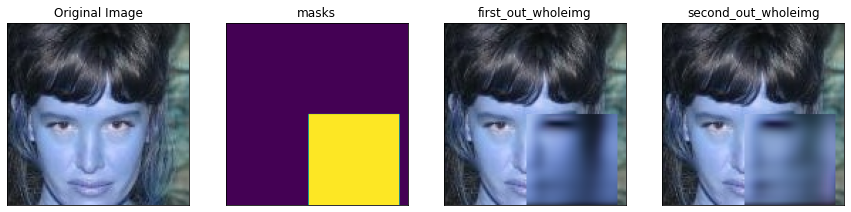

Epoch: 6, Step: 63, Training Losses - Generator: 18.020854949951172
0
Epoch: 6, Validation Losses - Generator: 12.39442331, Discriminator Global: 0.38999252, Discriminator Local: 0.30848886
Epoch: 6, Validation PSNR: 11.87318724, SSIM: 0.49789779


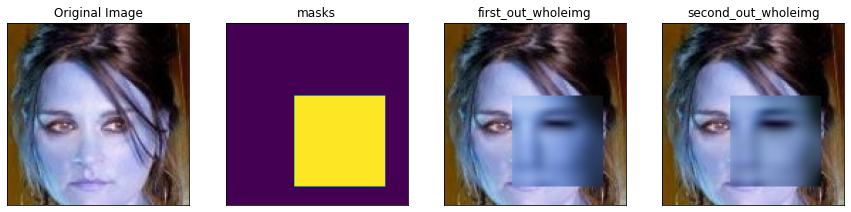

Epoch: 7, Step: 63, Training Losses - Generator: 15.988055229187012
0
Epoch: 7, Validation Losses - Generator: 12.63537759, Discriminator Global: 0.38919232, Discriminator Local: 0.30891879
Epoch: 7, Validation PSNR: 11.90705093, SSIM: 0.49889649


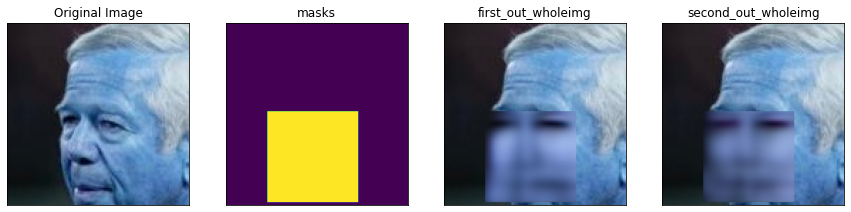

Epoch: 8, Step: 63, Training Losses - Generator: 16.976303100585938
0
Epoch: 8, Validation Losses - Generator: 12.88639712, Discriminator Global: 0.38919903, Discriminator Local: 0.30890736
Epoch: 8, Validation PSNR: 11.83206518, SSIM: 0.49745874


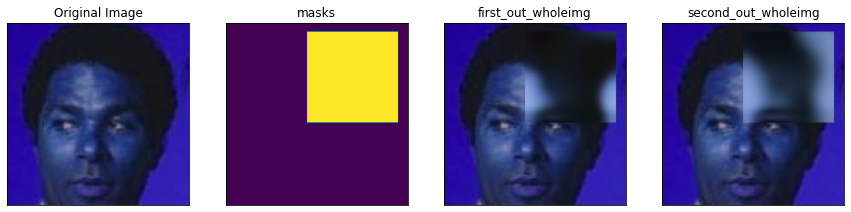

Epoch: 9, Step: 63, Training Losses - Generator: 18.310487747192383
0
Epoch: 9, Validation Losses - Generator: 13.03045827, Discriminator Global: 0.38946237, Discriminator Local: 0.30894846
Epoch: 9, Validation PSNR: 11.83614525, SSIM: 0.49626096


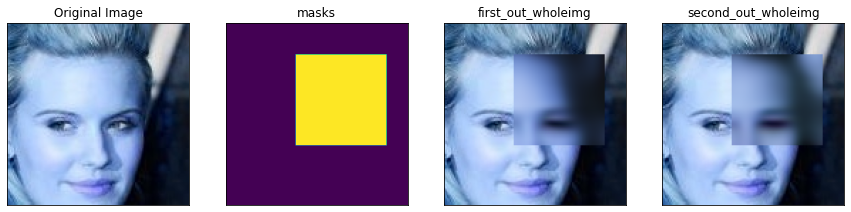

Epoch: 10, Step: 63, Training Losses - Generator: 17.321884155273438
0
Epoch: 10, Validation Losses - Generator: 12.45862919, Discriminator Global: 0.38968229, Discriminator Local: 0.30917538
Epoch: 10, Validation PSNR: 11.75437616, SSIM: 0.49742348


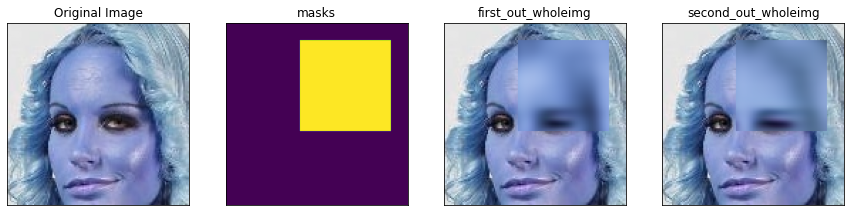

Epoch: 11, Step: 63, Training Losses - Generator: 18.4298152923584
0
Epoch: 11, Validation Losses - Generator: 12.64727342, Discriminator Global: 0.38935795, Discriminator Local: 0.30881918
Epoch: 11, Validation PSNR: 11.87545958, SSIM: 0.50223524
Early stopping triggered.


In [65]:
import random
import torch
import pandas as pd
#from utils.evaluate import evaluate_models, evaluate_model_external
num_epochs = 30
best_loss = float('inf')
patience = 5
lambda_gp = 10  # Gradient penalty weight
result_df = pd.DataFrame(columns= ['epoch', 'step', 'val_gen_loss', 'val_disc_global_loss', 'val_disc_local_loss', 'val_psnr', 'val_ssim' ])
generator.train()
discriminator_local.train()
discriminator_global.train()
for epoch in range(num_epochs):
    for i, (images, masks, masked_images) in enumerate(train_dataloader):
        # Resize the images and masks to a consistent size
       
        images = images.to(device)
        masked_images = masked_images.to(device)
        masks = masks.to(device)
        
        ## train discriminator
        optimizer_discriminator_global.zero_grad()
        optimizer_discriminator_local.zero_grad()
        optimizer_generator.zero_grad()
        
        first_out, second_out  = generator(images, masks)
        first_out_wholeimg = images * (1 - masks) + first_out * masks     
        second_out_wholeimg = images * (1 - masks) + second_out * masks 
        
        # Compute the adversarial loss for the generator using the global and local discriminators
         
        local_real_D = discriminator_local(images)
        local_fake_D = discriminator_local(second_out_wholeimg.detach())
        
        global_real_D = discriminator_global(images)
        global_fake_D = discriminator_global(second_out_wholeimg.detach())
  
        loss_local_fake_D = criterion_adv(local_fake_D, target_is_real=False)
        loss_local_real_D = criterion_adv(local_real_D, target_is_real=True)
        
        loss_global_fake_D = criterion_adv(global_fake_D, target_is_real=False)
        loss_global_real_D = criterion_adv(global_real_D, target_is_real=True)
   
        #gp = gradient_penalty(discriminator_global, images, completed_images)
        loss_d = (loss_local_real_D + loss_local_fake_D + loss_global_fake_D + loss_global_real_D) * 0.25 #+ lambda_gp * gp
        loss_d.backward(retain_graph=True)        
        
        optimizer_discriminator_global.step()
        optimizer_discriminator_local.step()
        
        local_real_output = None
        global_real_output = None
        
        # train generator
        optimizer_discriminator_global.zero_grad()
        optimizer_discriminator_local.zero_grad()
        optimizer_generator.zero_grad()
        
        # generator loss 
        local_fake_output = discriminator_local(second_out_wholeimg)
        global_fake_output = discriminator_global(second_out_wholeimg)
        fake_D = (local_fake_output + global_fake_output) * 0.5
        loss_G = criterion_adv(fake_D, target_is_real=True)
 
        local_fake_output = None
        global_fake_output = None
        fake_D = None
        
        
        # generator reconstruction loss
        # Reconstruction loss
        loss_l1_1 = criterion_rec(first_out_wholeimg, images)
        loss_l1_2 = criterion_rec(second_out_wholeimg, images)
        loss_ssim_1 = criterion_ssim(first_out_wholeimg, images)
        loss_ssim_2 = criterion_ssim(second_out_wholeimg, images)
        loss_rec_1 = 0.5 * loss_l1_1 + 0.5 * (1 - loss_ssim_1)
        loss_rec_2 = 0.5 * loss_l1_2 + 0.5 * (1 - loss_ssim_2)
        
        lambda_G = 1.0
        lambda_rec_1 = 100.0
        lambda_rec_2 = 100.0
        lambda_per = 10.0
        
        loss_P = criterion_parsing(face_parsing_model(second_out_wholeimg), face_parsing_model(images))
        loss_generator = lambda_G * loss_G + lambda_rec_1 * loss_rec_1 + lambda_rec_2 * loss_rec_2 + lambda_per * loss_P
        loss_generator.backward(retain_graph=True)
        optimizer_generator.step()
        if epoch == 5:
            adjust_learning_rate(optimizer_discriminator_global)
            adjust_learning_rate(optimizer_discriminator_local)
            adjust_learning_rate(optimizer_generator)
        if epoch == 10:
            adjust_learning_rate(optimizer_discriminator_global)
            adjust_learning_rate(optimizer_discriminator_local)
            adjust_learning_rate(optimizer_generator)
  
            
        if i % 10000 == 0:
            fig, axs = plt.subplots(1, 4, figsize=(15, 5))
            axs[0].imshow(return_image_numpy(images))
            axs[0].set_title("Original Image")
            axs[1].imshow(return_image_numpy(masks))
            axs[1].set_title("masks")
            axs[2].imshow(return_image_numpy(first_out_wholeimg))
            axs[2].set_title("first_out_wholeimg")
            axs[3].imshow(return_image_numpy(second_out_wholeimg))
            axs[3].set_title("second_out_wholeimg")

            for ax in axs:
                ax.set_xticks([])
                ax.set_yticks([])

            plt.show()
    
    # Evaluation
    # Inside your training loop, after each epoch
    print(f"Epoch: {epoch}, Step: {i}, Training Losses - Generator: {loss_generator.item()}") #, Discriminator Global: {loss_adv_global.item()}, Discriminator Local: {loss_adv_local.item()}")
    val_gen_loss, val_disc_global_loss, val_disc_local_loss = evaluate_models(generator, discriminator_global, discriminator_local, validation_dataloader, discriminator_loss, criterion_context, generator_loss, face_parsing_model, device)
    print(f"Epoch: {epoch}, Validation Losses - Generator: {val_gen_loss:.8f}, Discriminator Global: {val_disc_global_loss:.8f}, Discriminator Local: {val_disc_local_loss:.8f}")
    val_psnr, val_ssim = evaluate_model_external(generator, validation_dataloader, device)
    print(f"Epoch: {epoch}, Validation PSNR: {val_psnr:.8f}, SSIM: {val_ssim:.8f}")
    if epoch == 0:
        result_df = pd.DataFrame([{'epoch': epoch, 'step': i, 'val_gen_loss': val_gen_loss, 'val_disc_global_loss': val_disc_global_loss, 'val_disc_local_loss': val_disc_local_loss, 'val_psnr': val_psnr, 'val_ssim': val_ssim}])
    else:
        aa = pd.DataFrame([{'epoch': epoch, 'step': i, 'val_gen_loss': val_gen_loss, 'val_disc_global_loss': val_disc_global_loss, 'val_disc_local_loss': val_disc_local_loss, 'val_psnr': val_psnr, 'val_ssim': val_ssim}])
        result_df = pd.concat([result_df, aa], axis=0)
        result_df.to_csv('result.csv') 
    # Update the best loss and save the model if necessary
    
    if (val_gen_loss + val_disc_global_loss) < best_loss:
        best_loss = (val_gen_loss + val_disc_global_loss)
        best_generator = copy.deepcopy(generator.state_dict())
        best_discriminator_global = copy.deepcopy(discriminator_global.state_dict())
        best_discriminator_local = copy.deepcopy(discriminator_local.state_dict())
        # Save the best models
        torch.save({
                'D_G': best_discriminator_global,
                'D_L': best_discriminator_local,
                'G': best_generator,
        }, os.path.join("model_trained", f"model_{epoch}.pth"))
        counter = 0
    else:
        counter += 1

    # Check for early stopping
    if counter >= patience:
        print("Early stopping triggered.")
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


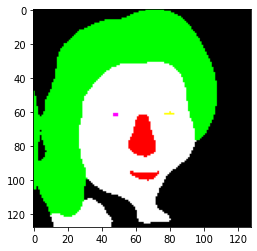

In [34]:
import numpy as np
test_predict = face_parsing_model(images)
pred_out = torch.argmax(test_predict[0], dim=0)
test_sam = pred_out.cpu().numpy()
parsed = decode_segmap(test_sam)
plt.imshow(parsed)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


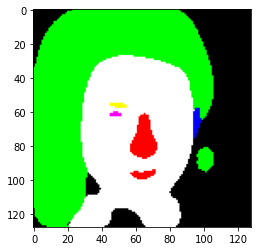

In [40]:
test_predict = face_parsing_model(images * (1-masks) + completed_images*masks)
pred_out = torch.argmax(test_predict[0], dim=0)
test_sam = pred_out.cpu().numpy()
parsed = decode_segmap(test_sam)
plt.imshow(parsed)

In [59]:
torch.cuda.empty_cache()

In [24]:

# for check the segmentation result with color
def get_parsing_labels():
    # background + 16 components
    return np.asarray([[0, 0, 0],
                      [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128],
                      [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0], [64, 128, 0],
                      [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128,128],
                      [0, 64, 0]])


def encode_segmap(mask):
    mask = mask.astype(int)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
    # pick pallete table from above and paint each values
    for i, label in enumerate(get_parsing_labels()):
        label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = i
    label_mask = label_mask.astype(int)

    return label_mask


# for colored output of segmentation
def decode_segmap(temp, plot=False):
    label_colors = get_parsing_labels()
    class_num = 17
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()

    for l in range(0, class_num):
        r[temp == l] = label_colors[l, 0]
        g[temp == l] = label_colors[l, 1]
        b[temp == l] = label_colors[l, 2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r
    rgb[:, :, 1] = g
    rgb[:, :, 2] = b

    return rgb
